In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
import warnings
import sys
import os
def nbipath():
    os.chdir('..')
    path = os.getcwd()+'/nbi'
    return path 

sys.path.insert(0, nbipath())
from nbi1 import *

from numpy.random import randn
from scipy.stats import anderson
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import scipy

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')

## Utility functions

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    
def createDictionary(dataframe_col1, dataframe_col2):
    """
    returns dictionary of structure number as key and and list of attribute belonging  to structure number
    :rtype: dictionary
    
    """
    # initialize the dictionary
    dictionary = {structure_number:[] for structure_number in dataframe_col1}
    
    for structure_number, value in zip(dataframe_col1, dataframe_col2):
        dictionary[structure_number].append(value)
    return dictionary


def createDictionaryOfMeanValue(dictionary):
    """
    returns dictionary of structure number as key and and mean values in corresponding to the structure number
    :rtype: dictionary
    
    """
    dictionary_new = {}
    
    for key, value in dictionary.items():
        mean_value = np.mean(value)
        dictionary_new[key] = mean_value
        
    return dictionary_new

def createDictionaryOfFirstValue(dictionary):
    dictionary_new = {}
    
    for key, value in dictionary.items():
        value = value[0]
        dictionary_new[key] = value
        
    return dictionary_new



## Importing dataset (Freeze-thaw / snowfall, Population)

In [3]:
# population dataset
df_csv = pd.read_excel('/Users/AkshayKale/Documents/github/data/population/PEP_2018_PEPANNRES_with_ann.xls', index_col=0)

# freeze-thaw/snowfall dataset
df_freeze_snow = pd.read_csv('/Users/AkshayKale/Documents/github/data/freezethaw-snowfall/freezethaw-snowfall-allstates-allyears.csv', index_col=0)

# structure number: county (dictionary)
d_structureNumber_county = createDictionary(df_freeze_snow['structure_number'], df_freeze_snow['COUNTY_NAME'])

# structure number: number of freezethaw (dictionary)
d_structureNumber_freeze_thaw = createDictionary(df_freeze_snow['structure_number'], df_freeze_snow['NO_OF_FREEZE_THAW_CYCLES'])

# structure number: number of snowfall (dictionary)
d_structureNumber_no_of_snowfall = createDictionary(df_freeze_snow['structure_number'], df_freeze_snow['no_of_snowfalls'])

In [4]:
# Resetting index of the population dataset
new_header = df_csv.iloc[0] #grab the first row for the header
df_csv = df_csv[1:] #take the data less the header row
df_csv.columns = new_header #set the header row as the df header

In [5]:
#  structure number: populationn (dictionary)
dict_county_population = {}
for county, population in zip(df_csv['Geography'], df_csv['Population Estimate (as of July 1) - 2018']):
    county_name, state = county.split(',')
    dict_county_population[county_name] = population

## Importing dataset (NBI)

In [6]:
csv_file = "/Users/AkshayKale/Documents/github/data/nbi/06-20-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

### Creating dictionary of structure number as key and snowfall, county, and freeze thaw as value

In [8]:
d_freeze_thaw = createDictionaryOfMeanValue(d_structureNumber_freeze_thaw)
d_snowfall = createDictionaryOfMeanValue(d_structureNumber_no_of_snowfall)
d_struct_county = {key: value[0] for key, value in d_structureNumber_county.items()}

In [9]:
# creating dictionary of structure number and population
d_structure_population = {}
for structure_number, county in d_struct_county.items():
    population = dict_county_population.get(county)
    d_structure_population[structure_number] = population

In [10]:
# selecting values that donot change structure length
df_wo = df_wo[df_wo['No Change structure length'] == True]
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]
df_wo = df_wo[df_wo['Structure Length']>6]

### Creating a new dataframe for mapping

In [27]:
mapping = df_wo
mapping['SN'] = [structureNumber[:-2] for structureNumber in mapping['Structure Number']]
mapping['No. of Freeze Thaw'] = mapping['SN'].map(d_freeze_thaw)
mapping['No. of Snow Fall'] = mapping['SN'].map(d_snowfall)
mapping['county'] = mapping['SN'].map(d_structureNumber_county)
mapping['population'] = mapping['SN'].map(d_structure_population)
mapping = mapping.dropna()
mapping['county'] = [county[0] for county in mapping['county']]
mapping['label'] = pd.qcut(mapping['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

### Utility functions for converting longitude and latitude

In [28]:
def makefloat(items):
    """
       Return a list of float from a list of strings.
    """
    items_int = []
    for item in items:
        try:
            items_int.append(float(item))
        except:
            pass
    return items_int
            
            
def getNonZeroValue(items):
    """
       Returns first non-zero value from the string.
    """
    for item in items:
        if item != 0.0:
            return item
        

def parseCoordinate(df_column): 
    """
       Returns a list of coordinatenate from list of lists of repeated or null coordinates.
    """
    coordinate = []
    for coords in df_column:
        list_coords = coords[1:-1].split(',')
        list_coords = makefloat(list_coords)
        coords = getNonZeroValue(list_coords)     
        coordinate.append(coords)
    return coordinate

mapping['longitude'] = parseCoordinate(mapping['Longitude'])
mapping['latitude'] = parseCoordinate(mapping['Latitude'])

## Creating a new dataframe

In [29]:
# categorizing freezethaw into very low, medium, and hard
mapping['freezethaw'] = pd.qcut(mapping['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

# categorizing snowfall into very low, medium, and hard
mapping['snowfall'] = pd.qcut(mapping['No. of Snow Fall'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = mapping[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code',
                       'Material','Structure Type', 'Maintainer','freezethaw', 'No. of Freeze Thaw', 'snowfall', 'No. of Snow Fall', 'Average ADT', 'Longitude', 'Latitude', 'population']]


df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               'freezethaw':'freezethaw',\
                                               'No. of Freeze Thaw':'numfreezethaw',
                                               'snowfall':'snowfall',
                                               'No. of Snow Fall':'numsnowfall',
                                               'Average ADT':'aadtt',
                                               'population':'population',
                                               'Longitude':'longitude',
                                               'Latitude':'latitude'
                                              })

### Saving dataset

In [30]:
df_anova_mapping = df_anova[['numsnowfall', 'longitude', 'latitude', 'score', 'snowfall', 'freezethaw', 'population']]
df_anova_mapping.to_csv('../data/nbi/mapping-population.csv')

## Correlation Matrix

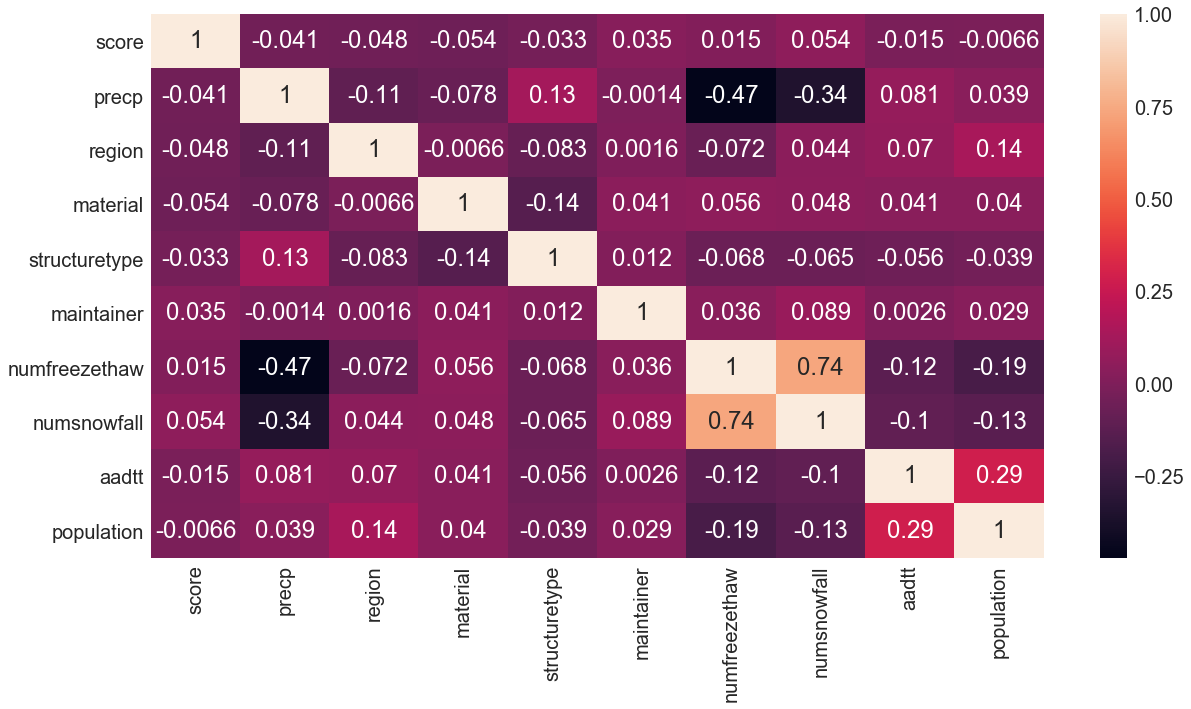

In [45]:
plt.figure(figsize = (20,10))
corr = df_anova.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot = True)
plt.show()